In [32]:
import os
import glob
import time
from datetime import datetime

import torch
import numpy as np
import pandas as pd

from State import State
from GenerateDemandMonthly import GenerateDemandMonthly

from PPO import PPO

from scipy import stats

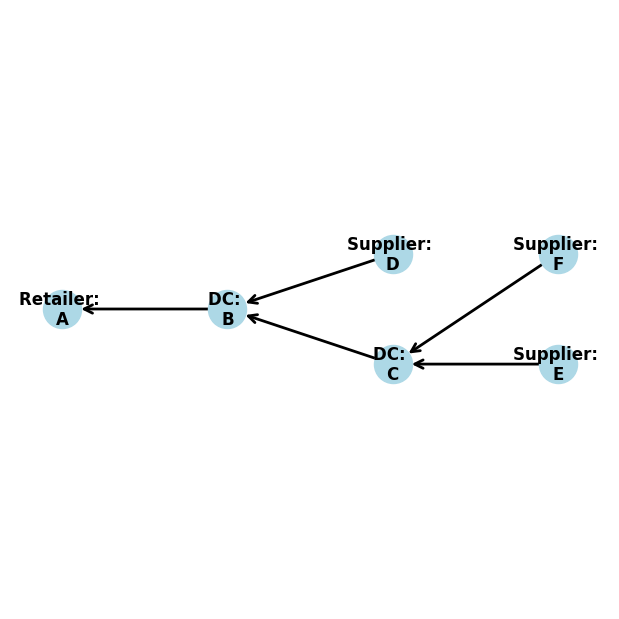

In [33]:
env = State()
env.create_state([-1, 0, 1, 1, 2, 2])
env.show_network()

In [34]:
env = State()
env.create_state([-1, 0, 1, 1, 2, 2])
dimension = len(env.action_map)

In [35]:
has_continuous_action_space = False # continuous action space; else discrete
action_std = 0.6            # starting std for action distribution (Multivariate Normal)

eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor
K_epochs = 20
lr_actor = 0.00005      # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 1234         # set random seed if required (0 = no random seed)

state_dim = 9
action_dim = dimension

In [36]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.policy_old.load_state_dict(torch.load(map_location=torch.device('cpu'),f="rlmodel4.pt"))
ppo_agent.policy.load_state_dict(torch.load(map_location=torch.device('cpu'),f="rlmodel4.pt"))

<All keys matched successfully>

In [37]:

#### Generate New Demand ####
demand_generator = GenerateDemandMonthly()

df = pd.read_csv("../src/TOTALSA.csv")
mean = df['TOTALSA'].mean()
std = df['TOTALSA'].std()
period = 108
iterations = 500

np.random.seed(1234)
demand_matrix = np.reshape(demand_generator.simulate_normal_no_season(\
            periods = period * iterations, mean=mean, std=std),\
                (iterations, period))

In [38]:
np.random.seed(5678)
reward_RL = []

for demand_list in demand_matrix:
    reward_total = 0
    state = env.reset()
    env.set_demand_list(demand_list)
    done = False
    reward_sub = 0
    
    while not done:
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)
        reward_sub += reward
        print(reward)
        if done:
            break
    reward_total += reward_sub
    reward_RL.append(reward_total)
        

766.5999999999999
492.1999999999998
1172.8
946.3999999999999
944.3999999999999
1093.1999999999998
1179.1999999999998
945.3999999999999
979.0
660.0
1219.8
1199.1999999999998
477.4
1402.3999999999999
781.3999999999999
979.0
1086.6
1073.6
1278.8
631.1999999999998
1024.0
893.3999999999999
845.8
1405.3999999999999
1322.8
1005.3999999999999
486.0
1377.8
987.0
1125.6
1008.5999999999999
1131.6
-269.8
1780.3999999999996
2002.6
998.0
560.0
1385.3999999999999
449.4
2203.3999999999996
1.3999999999999773
1155.1999999999998
1606.8
459.0
1090.6
746.8
-24.200000000000045
2087.2
789.1999999999998
1455.6
407.79999999999995
1467.6
790.1999999999998
748.1999999999998
1139.1999999999998
878.8
1024.0
1249.8
1095.6
1365.3999999999999
893.8
1028.0
980.5999999999999
1047.0
1206.1999999999998
590.0
1494.0
858.8
1024.6
871.8
916.8
804.8
1804.3999999999996
484.4
1406.0
1431.0
472.4
840.8
1815.3999999999996
1012.0
1103.6
383.19999999999993
1242.8
1053.0
495.4
1515.6
1147.1999999999998
1198.1999999999998
1094.6
457

In [39]:
print(reward_RL)

[109546.00000000001, 103415.20000000003, 104551.19999999995, 104657.79999999999, 105376.60000000002, 103888.4, 102806.40000000002, 106893.6, 106875.59999999998, 105138.20000000003, 93837.00000000003, 102950.6, 104582.59999999999, 100142.6, 107480.8, 108577.59999999996, 103460.79999999997, 107451.19999999997, 89554.59999999993, 106783.00000000003, 101577.59999999998, 109046.19999999997, 111710.20000000007, 98146.80000000003, 103716.39999999998, 108410.40000000001, 106016.19999999997, 93071.20000000001, 107986.00000000007, 100974.19999999998, 103099.6, 97949.8, 106661.00000000004, 106340.0, 99179.59999999998, 93768.79999999993, 105979.20000000004, 105987.99999999997, 82369.20000000001, 111752.4, 102783.4, 108635.59999999998, 86750.59999999999, 107622.00000000003, 105687.59999999999, 105266.40000000001, 111671.20000000004, 106962.8, 100372.6, 89361.4, 102710.99999999999, 107248.79999999997, 105344.39999999998, 100745.99999999999, 105116.59999999998, 103856.39999999995, 69322.59999999999, 

In [40]:
## Starting inventory is fixed at 65
print(np.mean(reward_RL))

103484.72959999999


In [41]:
print(stats.sem(reward_RL))

230.5574376883873


In [42]:
np.random.seed(7890)
#### Generate New Demand ####
demand_generator = GenerateDemandMonthly()

df = pd.read_csv("../src/TOTALSA.csv")
mean = df['TOTALSA'].mean()
std = df['TOTALSA'].std()
period = 108
iterations = 500

demand_matrix = np.reshape(demand_generator.simulate_normal_no_season(\
            periods = period * iterations, mean=mean, std=std),\
                (iterations, period))

In [43]:
real_data = df["TOTALSA"].round().tolist()


In [49]:
reward_total = 0
state = env.reset()
env.set_demand_list(real_data)
done = False
reward_sub = 0

while not done:
    action = ppo_agent.select_action(state)
    state, reward, done = env.step(action)
    reward_sub += reward
    print(reward)
    if done:
        print(env.curr_time)
        break
reward_total += reward_sub
print("reward total", reward_total)

488.79999999999995
566.8
698.8
825.8
696.8
699.8
712.8
681.8
888.3999999999999
893.8
887.8
950.0
954.3999999999999
1024.0
842.0
908.0
1083.0
904.0
929.0
979.0
1099.0
934.0
1094.0
541.0
1447.3999999999999
232.5999999999999
1657.8
1231.6
1002.5999999999999
1166.6
981.5999999999999
1064.6
989.0
1191.6
565.4
582.5999999999999
1895.0
-460.0
2333.0
78.0
982.0
1597.1999999999998
933.3999999999999
391.79999999999995
923.3999999999999
1366.3999999999999
839.8
820.8
889.3999999999999
813.8
726.1999999999998
538.0
654.0
533.0
710.1999999999998
652.5999999999999
650.5999999999999
620.5999999999999
688.5999999999999
705.5999999999999
666.5999999999999
719.1999999999998
700.1999999999998
522.0
562.0
526.0
601.0
-399.0
1819.3999999999996
407.4
457.4
428.4
577.0
268.19999999999993
983.0
592.0
607.5999999999999
582.0
534.0
582.0
650.5999999999999
532.0
717.1999999999998
630.5999999999999
713.5999999999999
589.5999999999999
667.5999999999999
658.1999999999998
712.1999999999998
680.5999999999999
998.0
48

In [45]:
print(np.mean(reward_RL))

103484.72959999999


100222.47159999999 #RL model 1
100153.98079999999 #RL model 2
103739.64319999999 #RL model 4